Station Metadata:
* usaf = Air Force station ID.
* wban = NCDC WBAN number
* name = Station Name
* country = FIPS country ID
* state = State for US stations
* ICAO = ICAO ID
* LAT = Latitude in thousandths of decimal degrees
* LON = Longitude in thousandths of decimal degrees
* ELEV = Elevation in meters
* BEGIN = Beginning Period Of Record (YYYYMMDD). There may be reporting gaps within the P.O.R.
* END = Ending Period Of Record (YYYYMMDD). There may be reporting gaps within the P.O.R.

In [0]:
pip install haversine

Python interpreter will be restarted.
Collecting haversine
 Downloading haversine-2.3.0-py2.py3-none-any.whl (5.5 kB)
Installing collected packages: haversine
Successfully installed haversine-2.3.0
Python interpreter will be restarted.

In [0]:
pip install timezonefinder

Python interpreter will be restarted.
Requirement already satisfied: timezonefinder in /local_disk0/.ephemeral_nfs/envs/pythonEnv-3db87d98-52bd-4d4b-9cfd-66dabc335d53/lib/python3.7/site-packages (4.5.0)
Requirement already satisfied: numpy>=1.16 in /local_disk0/.ephemeral_nfs/envs/pythonEnv-3db87d98-52bd-4d4b-9cfd-66dabc335d53/lib/python3.7/site-packages (from timezonefinder) (1.18.1)
Python interpreter will be restarted.

In [0]:
from pyspark.sql import functions as f
from pyspark.sql.functions import concat, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext

from haversine import haversine, Unit
from timezonefinder import TimezoneFinder

sqlContext = SQLContext(sc)


In [0]:
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz")

In [0]:
stations.printSchema()

root
-- usaf: string (nullable = true)
-- wban: string (nullable = true)
-- name: string (nullable = true)
-- country: string (nullable = true)
-- state: string (nullable = true)
-- call: string (nullable = true)
-- lat: string (nullable = true)
-- lon: string (nullable = true)
-- elev: string (nullable = true)
-- begin: string (nullable = true)
-- end: string (nullable = true)

In [0]:
# How many stations are there?
stations.count()

Out[5]: 29771

In [0]:
# How many stations in the US?
us_stations = stations.where('end > "20150101"')
us_stations.count()

Out[58]: 15012

In [0]:
# descriptive summary
display(us_stations.describe())

summary,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
count,3329,3329,3329,3329,3124,2516,3317,3317,3317,3329,3329
mean,788888.0437291224,53748.597176329225,null,null,null,null,39.3243189629183,-97.54611094362359,347.3342779620138,1.9982015581255633E7,2.018734117843196E7
stddev,116780.38947085505,41577.47389734176,null,null,null,null,8.840043020614432,25.078363080794855,527.7677176823934,200345.75974269776,5199.81714226009
min,690150,00102,068: BAFFIN BAY; POINT OF ROC,US,AK,K04V,13.54,-1.7,+0000.0,19310101,20150128
max,A51256,99999,ZEPHYRHILLS MUNICIPAL AIRPORT,US,WY,TJNR,8.73,2.117,-0036.0,20181017,20190305


In [0]:
# How many US stations active during time period (2015-01-01 to 2015-06-30)?
us_stations.where('(begin <= 20150630 OR end >= 20150101)').count()

Out[46]: 3329

In [0]:
# How many US stations were active for less than the range (started and ended within the period) (2015-01-01 to 2015-06-30)?
us_stations.where('begin >= 20150101 AND end <= 20150630').count()

Out[9]: 0

In [0]:
# Which US stations deactivated during the range (2015-01-01 to 2015-06-30)?
display(us_stations.where('end >= 20150101 AND end <= 20150630'))

usaf,wban,name,country,state,call,lat,lon,elev,begin,end
720466,99999,SUPERDOME HELIPORT,US,LA,KVSH,29.95,-90.083,+0015.2,20120726,20150128
722825,53145,TONOPAH TEST RANGE #74,US,NV,KBJN,37.617,-116.264,+1755.7,20060101,20150201
722890,93136,MOUNT WILSON,US,CA,KMWS,34.233,-118.067,+1739.2,19500101,20150513
999999,00483,NEW ORLEANS SUPERDOME HELIPOR,US,LA,null,29.953,-90.083,+0009.1,20140731,20150128
A00026,94297,COUPEVILLE/NOLF,US,WA,KNRA,48.217,-122.633,+0060.7,20060324,20150514
722408,99999,INTRACOASTAL CITY,US,LA,K7R4,29.767,-92.117,+0005.0,19760101,20150407


In [0]:
# Which US stations activating during the range (2015-01-01 to 2015-06-30)?
display(us_stations.where('begin >= 20150101 AND begin <= 20150630'))

usaf,wban,name,country,state,call,lat,lon,elev,begin,end
720488,99999,SIKESTON MEM MUNI,US,MO,KSIK,36.899,-89.562,+0096.0,20150128,20190303
720572,99999,BOLINDER FIELD TOOELE VALLEY,US,UT,KTVY,40.612,-112.351,+1316.1,20150506,20190303
720907,99999,CAMPBELL CO,US,TN,KJAU,36.335,-84.162,+0359.7,20150608,20190303
A05735,00209,BOWIE MUNICIPAL AIRPORT,US,TX,K0F2,33.6,-97.783,+0336.2,20150101,20190304
A06800,00120,TAZEWELL COUNTY AIRPORT,US,VA,KJFZ,37.067,-81.8,+0808.6,20150101,20190305


In [0]:
# Get the weather data
weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/*.parquet")
f'{weather.count():,}'

Out[5]: '632,050,898'

In [0]:
# dataframe for stations activated during date range
stations_us_activated = us_stations.where('country == "US" AND begin >= 20150101 AND begin <= 20150630').withColumn('station_id', f.concat(f.col('usaf'), f.col('wban')))
# dataframe for stations deactivated during date range
stations_us_deactivated = us_stations.where('country == "US" AND end >= 20150101 AND end <= 20150630').withColumn('station_id', f.concat(f.col('usaf'), f.col('wban')))
# dataframe for stations active at all during date range
stations_us_active = us_stations.where('country == "US" AND (begin <= 20150630 OR end >= 20150101)').withColumn('station_id', f.concat(f.col('usaf'), f.col('wban')))
# weather within date range
weather_in_range = weather.where('DATE >= "2015-01-01T00:00:00" AND DATE <= "2015-06-30T23:59:59"').withColumn('station_date', f.date_format('DATE','yyyyMMdd'))

In [0]:
# looking for mistakes in the weather data.  Are there any weather values from before the station begin date?
stations_us_activated.join(weather_in_range, [weather_in_range.STATION == stations_us_activated.station_id, stations_us_activated.begin > weather_in_range.station_date]).count()

Out[14]: 0

In [0]:
# looking for mistakes in the weather data.  Are there any weather values that end after the station end date?
stations_us_deactivated.join(weather_in_range, [weather_in_range.STATION == stations_us_deactivated.station_id, stations_us_deactivated.end < weather_in_range.station_date]).count()

Out[15]: 0

In [0]:
# How many weather measurements does each station have? If measurements are hourly it should be 180x24 = 4320
weather_measurements_per_station = stations_us_active.join(weather_in_range, [weather_in_range.STATION == stations_us_active.station_id]).groupBy('station_id').count()
wmps_df = weather_measurements_per_station.toPandas()

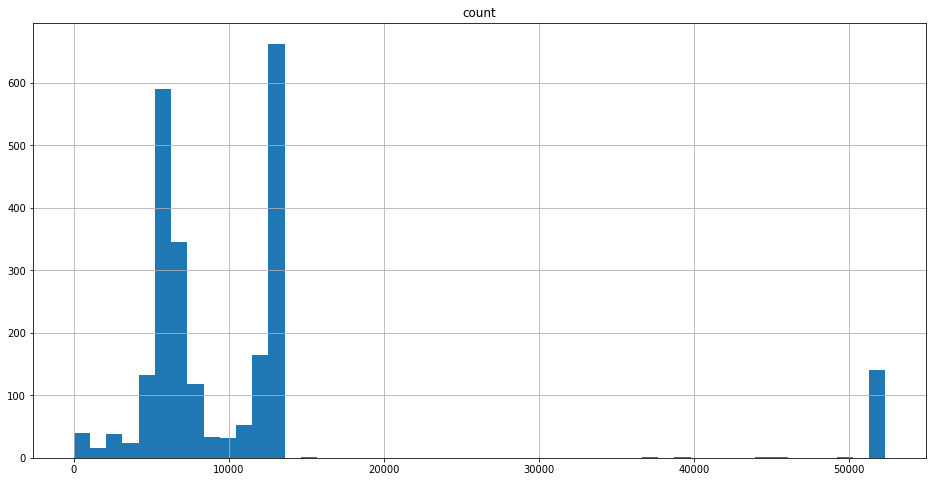

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-1722483348770354> in <module> 
 1 # Trying to plot the histogram. Not sure about labeling in databricks 
 2 ax = wmps_df . hist ( figsize = ( 16 , 8 ) , bins = 50 ) 
 ----> 3 ax . set_xlabel = 'Measurements' 
 4 ax . set_ylabel = 'Station Count' 

 AttributeError : 'numpy.ndarray' object has no attribute 'set_xlabel'

In [0]:
# Trying to plot the histogram.  Not sure about labeling in databricks
ax = wmps_df.hist(figsize=(16,8),bins=50)
ax.set_xlabel='Measurements'
ax.set_ylabel='Station Count'

In [0]:
# tried using databrick plotting, but not 100% sure how this works
display(weather_measurements_per_station)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1722483348770355> in <module> 
 1 # tried using databrick plotting, but not 100% sure how this works 
 ----> 2 display ( weather_measurements_per_station ) 

 NameError : name 'weather_measurements_per_station' is not defined

In [0]:
# save out the low and high count stations
low_count_stations = weather_measurements_per_station.where('count < 3500').withColumnRenamed("station_id", "station_count_id")   
high_count_stations = weather_measurements_per_station.where('count > 13000').withColumnRenamed("station_id", "station_count_id")   
low_count_stations.join(stations_us_active, [low_count_stations.station_count_id == stations_us_active.station_id]).write.format('com.databricks.spark.csv').option('header', 'true').save('dbfs:/mnt/mids-w261/team20SSDK/data/station/low_weather_measurement_stations.csv')
high_count_stations.join(stations_us_active, [high_count_stations.station_count_id == stations_us_active.station_id]).write.format('com.databricks.spark.csv').option('header', 'true').save('dbfs:/mnt/mids-w261/team20SSDK/data/station/high_weather_measurement_stations.csv')

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-231034620067001> in <module> 
 2 low_count_stations = weather_measurements_per_station . where ( 'count < 3500' ) . withColumnRenamed ( "station_id" , "station_count_id" ) 
 3 high_count_stations = weather_measurements_per_station . where ( 'count > 13000' ) . withColumnRenamed ( "station_id" , "station_count_id" ) 
 ----> 4 low_count_stations . join ( stations_us_active , [ low_count_stations . station_count_id == stations_us_active . station_id ] ) . write . format ( 'com.databricks.spark.csv' ) . option ( 'header' , 'true' ) . save ( 'dbfs:/mnt/mids-w261/team20SSDK/data/station/low_weather_measurement_stations.csv' ) 
 5 high_count_stations . join ( stations_us_active , [ high_count_stations . station_count_id == stations_us_active . station_id ] ) . write . format ( 'com.databricks.spark.csv' ) . option ( 'header' , 'true' ) . save ( 'dbfs:/mnt/mids-w261/team20SSDK/data/station/high_weather_measurement_stations.csv' ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in save (self, path, format, mode, partitionBy, **options) 
 828 self . _jwrite . save ( ) 
 829 else : 
 --> 830 self . _jwrite . save ( path ) 
 831 
 832 @ since ( 1.4 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1303 answer = self . gateway_client . send_command ( command ) 
 1304 return_value = get_return_value(
 -> 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 
 1307 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 131 # Hide where the exception came from that shows a non-Pythonic 
 132 # JVM exception message. 
 --> 133 raise_from ( converted ) 
 134 else : 
 135 raise 

 /databricks/spark/python/pyspark/sql/utils.py in raise_from (e) 

 AnalysisException : path dbfs:/mnt/mids-w261/team20SSDK/data/station/low_weather_measurement_stations.csv already exists.;

In [0]:
# Details on the stations lowest counts of weather metrics
display(low_count_stations.join(stations_us_active, [low_count_stations.station_count_id == stations_us_active.station_id]))

station_count_id,count,usaf,wban,name,country,state,call,lat,lon,elev,begin,end,station_id
72295503174,2486,722955,03174,ZAMPERINI FIELD AIRPORT,US,CA,KTOA,33.803,-118.34,+0029.6,20060101,20190304,72295503174
78514011603,2941,785140,11603,RAFAEL HERNANDEZ AIRPORT,US,PR,TJBQ,18.498,-67.129,+0066.5,20060101,20190303,78514011603
78514511653,522,785145,11653,EUGENIO MARIA DE HOSTOS AIRPO,US,PR,TJMZ,18.254,-67.149,+0011.6,20050101,20170810,78514511653
78526500494,2348,785265,00494,FERNANDO LUIS RIBAS DOMINICCI,US,PR,TJIG,18.457,-66.098,+0003.1,20110223,20190303,78526500494
72062500212,2999,720625,00212,BLACKWELL TONKAWA MUNICIPAL A,US,OK,KBKN,36.75,-97.35,+0314.3,20090312,20190305,72062500212
99999900481,2907,999999,00481,GRANITE PEAK FILLMORE ARPT,US,UT,null,38.958,-112.363,+1519.4,20140730,20190303,99999900481
99999900483,1979,999999,00483,NEW ORLEANS SUPERDOME HELIPOR,US,LA,null,29.953,-90.083,+0009.1,20140731,20150128,99999900483
74780863803,2653,747808,63803,GWINNETT CO-BRISCOE FD APT,US,GA,KLZU,33.98,-83.963,+0323.4,20060101,20190304,74780863803
72494693232,2719,724946,93232,REID-HILLVIEW AIRPORT OF SANT,US,CA,KRHV,37.333,-121.817,+0040.5,20060101,20190304,72494693232
74781263813,2988,747812,63813,COBB CO-MC COLLUM FLD ARPT,US,GA,KRYY,34.013,-84.599,+0317.0,20060101,20190304,74781263813


In [0]:
# Details on the stations highest counts of weather metrics
display(high_count_stations.join(stations_us_active, [high_count_stations.station_count_id == stations_us_active.station_id]))

station_count_id,count,usaf,wban,name,country,state,call,lat,lon,elev,begin,end,station_id
99999953139,52303,999999,53139,STOVEPIPE WELLS 1 SW,US,CA,null,36.602,-117.145,+0025.6,20040504,20190301,99999953139
99999953152,52315,999999,53152,SANTA BARBARA 11 W,US,CA,null,34.414,-119.88,+0005.5,20080814,20190301,99999953152
99999904990,52315,999999,04990,SIOUX FALLS 14 NNE,US,SD,null,43.735,-96.622,+0485.9,20020728,20190228,99999904990
99999953155,52315,999999,53155,WILLIAMS 35 NNW,US,AZ,null,35.755,-112.337,+1825.8,20080626,20190301,99999953155
99999921515,52315,999999,21515,HILO 5 S,US,HI,null,19.645,-155.083,+0189.6,20050927,20190228,99999921515
99999953961,52315,999999,53961,MONROE 26 N,US,LA,null,32.883,-92.117,+0026.8,20030115,20190301,99999953961
99999953877,52315,999999,53877,ASHEVILLE 8 SSW,US,NC,null,35.495,-82.614,+0655.6,20001120,20190301,99999953877
99999953136,52315,999999,53136,MERCURY 3 SSW,US,NV,null,36.624,-116.023,+1001.0,20010524,20190301,99999953136
99999953926,52315,999999,53926,STILLWATER 2 W,US,OK,null,36.118,-97.091,+0271.3,20020312,20190301,99999953926
99999912987,52315,999999,12987,EDINBURG 17 NNE,US,TX,null,26.526,-98.063,+0019.5,20040219,20190228,99999912987


# Now with full dataset

In [0]:
us_stations.registerTempTable('us_stations_table')
us_stations_df = sqlContext.sql('select *, if(begin < "20150101","20150101",begin) as begin_dataset from us_stations_table')
us_stations_df.show()

+------+-----+--------------------+-------+-----+-----+------+--------+-------+--------+--------+-------------+
 usaf| wban| name|country|state| call| lat| lon| elev| begin| end|begin_dataset|
+------+-----+--------------------+-------+-----+-----+------+--------+-------+--------+--------+-------------+
700635|26465|GALBRAITH LAKE AI...| US| AK| PAGB|68.479| -149.49|+0812.6|20060105|20190227| 20150101|
701195|26625|SHISHMAREF/NEW AI...| US| AK| PASH| 66.25|-166.089|+0002.1|20060101|20190223| 20150101|
701486|26642| KIVALINA AIRPORT| US| AK| PAVL|67.732|-164.548|+0003.1|20060101|20190224| 20150101|
701719|00490| SHUNGNAK AIRPORT| US| AK| PAGH|66.888|-157.162|+0062.8|20091210|20190125| 20150101|
701748|99999|PROSPECT CREEK AI...| US| AK| PAPR|66.817| -150.65|+0335.0|19730825|20190213| 20150101|
701995|26628|CAPE DARBY REMOT ...| US| AK| PAGL| 64.55|-163.007|+0007.6|20050101|20190228| 20150101|
702223|26602| KOYUK AIRPORT| US| AK| PAKK|64.935|-161.155|+0033.5|20060101|20190228| 20150101|
702550|26514| SKWENTNA AIRPORT| US| AK| PASW|61.977|-151.217|+0045.7|19730101|20161001| 20150101|
702628|99999|MARSHALL DON HUNT...| US| AK| PADM|61.864|-162.026|+0031.4|20080101|20180103| 20150101|
702697|99999| NEW STUYAHOK| US| AK| PANW| 59.45| -157.33|+0092.0|20080101|20180322| 20150101|
702700|99999|FT. RICHARDSON/BR...| US| null| PAFR|61.267| -149.65|+0115.0|19731201|20180520| 20150101|
702717|99999| SELAWIK| US| AK| PALK| 66.6|-159.986|+0007.6|19730101|20160930| 20150101|
702986|26557| BIG RIVER LAKE| US| AK| PALV|60.814|-152.297|+0018.3|20060101|20180324| 20150101|
703051|26521| HOLY CROSS AIRPORT| US| AK| PAHC|62.183|-159.767|+0006.1|20060101|20181213| 20150101|
703055|99999| MANOKOTAK| US| AK| PAMB| 58.99| -159.05|+0016.0|20080101|20180322| 20150101|
703406|26546|PORT ALSWORTH AIR...| US| AK| PALJ|60.204|-154.316|+0079.3|20050101|20190225| 20150101|
703817|25357|ELFIN COVE SEAPLA...| US| AK| PAEL|58.192|-136.344|+0006.1|20060101|20181218| 20150101|
703886|25348| PORT ALEXANDER SPB| US| AK| PAAP|56.247|-134.645|+0003.7|20060101|20151117| 20150101|
703925|99999| KOLIGANEK| US| AK| PAJZ| 59.73| -157.26|+0082.0|20080101|20180322| 20150101|
720122|00114|STARR BROWNING AI...| US| MT|K8S0 | 48.6|-113.117|+1419.2|20140731|20150930| 20150101|
+------+-----+--------------------+-------+-----+-----+------+--------+-------+--------+--------+-------------+
only showing top 20 rows

In [0]:
def begin_dataset(value):
  if value < '20150101':
    return '20150101'
  else:
    return value
    
udf_begin_dataset = f.udf(begin_dataset, StringType())

us_stations_df = us_stations.withColumn("begin_dataset", udf_begin_dataset("begin"))


In [0]:
display(us_stations_df)

usaf,wban,name,country,state,call,lat,lon,elev,begin,end,begin_dataset
690014,99999,C STN WHITE SANDS,US,NM,null,32.35,-106.367,+1224.0,19870101,19910611,20150101
690020,93218,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36,-121.233,+0317.0,19640715,19970401,20150101
690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36,-121.233,+0317.0,20030702,20030801,20150101
690070,93217,FRITZSCHE AAF,US,CA,KOAR,36.683,-121.767,+0043.0,19600404,19930831,20150101
690110,99999,SELFRIDGE ANGB/TRAIN,US,MI,null,42.608,-82.835,+0177.0,19430614,19920507,20150101
690140,93101,EL TORO MCAS,US,CA,KNZJ,33.667,-117.733,+0116.7,19890101,19990630,20150101
690150,99999,TWENTYNINE PALMS,US,CA,KNXP,34.3,-116.167,+0626.0,19891115,19891229,20150101
690169,99999,TUSTIN MCAS,US,CA,null,33.7,-117.83,+0017.0,19960101,19961231,20150101
690174,99999,INDIAN SPRINGS RANGE,US,NV,L63,36.533,-115.567,+0972.0,19780823,19800430,20150101
690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.433,-99.85,+0545.3,19431201,20121231,20150101


# Working with station nearest neighbors
## Let's reduce the station list to the ones that are within 50 miles of an airport

In [0]:
# Code from Sanjay's notebook:
locations = stations.where('country == "US" OR country == "GQ" OR country == "PR"').select(concat(col("usaf"), col("wban")).alias("station_id"), col("lat"), col("lon")).distinct().where(col("lat").isNotNull()).where(col("lon").isNotNull())
display(locations)

###

locations = locations.toPandas()
locations

###
coords = []

for long, lat, station_id in zip(locations['lat'], locations['lon'], locations['station_id']):
    coords.append((float(lat),float(long), station_id))

print(coords)

###
from itertools import permutations

coords_list = []

for combo in permutations(coords, 2): 
    coords_list.append(combo)
    
###

coords_rdd = sc.parallelize(coords_list)
coords_rdd.count()

###

def calcHaversine(x):
    origin, dest = x[0], x[1]
    dest_dict = {}
    dist = haversine(origin[:2], dest[:2], unit=Unit.MILES)
    dest_dict[dest] = dist
    return (origin, dest_dict)
  
def updateDict(x, y):
    x.update(y)
    return x

result = coords_rdd.map(lambda x: calcHaversine(x)) \
                   .reduceByKey(lambda x, y: updateDict(x, y)).cache()

result.collect()

###

def getStationNeighbors(x):
    origin, dest = x[0], x[1]
    yield (origin[2], origin[2])
    sorted_list = [str(i[0][2]) for i in filter(lambda x: x[1] <= 50.0, sorted(dest.items(), key=lambda x: x[1])[:5])]
    for i in sorted_list:
        yield(origin[2], i)

clusters = result.flatMap(lambda x: getStationNeighbors(x)).cache()

clusters.collect()

###

station_neighbors = spark.createDataFrame(clusters).toDF("station_id", "neighbor_id")
display(station_neighbors)
station_neighbors.count()

###

station_id,lat,lon
40778099999,47.867,10.617
72292399999,33.3,-117.35
72407613724,39.379,-74.424
72574124027,41.594,-109.053
69180499999,29.967,-81.983
69270499999,32.033,-81.667
72046799999,30.814,-89.865
72091399999,27.833,-91.983
72469699999,39.95,-105.833
72562799999,42.05,-101.07


[(10.617, 47.867, '40778099999'), (-117.35, 33.3, '72292399999'), (-74.424, 39.379, '72407613724'), (-109.053, 41.594, '72574124027'), (-84.833, 39.767, '74901599999'), (-121.3, 37.6, '74918099999'), (-101.046, 39.428, '99999903037'), (-118.233, 33.75, '99999903157'), (-81.806, 30.278, '99999953894'), (-67.883, 46.96, '99999994645'), (-89.22, 28.17, '72035299999'), (-80.92, 29.07, '72205899999'), (-86.689, 36.119, '99999913897'), (-161.167, 64.933, '70222399999'), (-94.483, 36.2, '72344399999'), (-131.02, 46.05, '99221099999'), (1.4, 57.7, '99506099999'), (-164.65, 67.57, '99770499999'), (-101.674, 47.896, '72101699999'), (-89.153, 41.352, '72214904899'), (-90.652, 40.52, '72215704949'), (-106.948, 47.326, '72768494051'), (-109.483, 37.583, 'A0001603036'), (-79.733, 34.617, '72063100217'), (-90.45, 27.63, '72091600453'), (-81.983, 29.967, '69180499999'), (-81.667, 32.033, '69270499999'), (-89.865, 30.814, '72046799999'), (-91.983, 27.833, '72091399999'), (-105.833, 39.95, '72469699999'), (-101.07, 42.05, '72562799999'), (-115.667, 36.583, '74614199999'), (-124.244, 43.413, '99999924284'), (-121.767, 36.683, '99999993217'), (-80.652, 38.687, 'A0001263879'), (-76.0, 37.25, '72402899999'), (-79.853, 38.885, '99999913729'), (-120.531, 47.033, '72788399999'), (-93.333, 30.833, '72233499999'), (-94.183, 42.55, '72549099999'), (-68.367, 44.45, '72607799999'), (-87.22, 47.18, '99420099999'), (-74.067, 40.65, '99774399999'), (-88.233, 47.183, '99817699999'), (-65.017, 20.983, '99798699999'), (-134.412, 58.298, '99826199999'), (-121.907, 36.626, '99833499999'), (-90.117, 30.017, '99819499999'), (-90.411, 32.304, '72078700278'), (-110.721, 35.028, '72374023194'), (-94.731, 39.297, '72446003947'), (-97.267, 37.617, '72450503923'), (-99.267, 38.85, '72451803968'), (-104.338, 37.262, '72464523070'), (-95.348, 48.941, '72654804971'), (-92.483, 44.017, '99999900343'), (-69.712, 43.964, '72713594623'), (-98.695, 29.724, '72073399999'), (-117.65, 34.067, '72286599999'), (-117.833, 33.7, '72291593114'), (-69.55, 45.45, '72607499999'), (-103.862, 44.734, '72660699999'), (-69.933, 43.9, '74392014611'), (-86.733, 30.617, '74901499999'), (-155.667, 19.0, '91294099999'), (-111.978, 37.517, '99999903081'), (-78.15, 38.067, '99999913732'), (-97.68, 30.183, '99999913904'), (-76.43, 38.9, '72404799999'), (135.0, 29.0, '99228099999'), (-80.083, 26.317, '99417099999'), (-146.5, 70.233, '70086699999'), (-74.8, 40.267, '72409599999'), (-115.667, 47.45, '72681799999'), (-113.33, 42.32, '72586999999'), (-113.014, 36.96, '99999953129'), (-91.567, 34.6, '72341699999'), (-81.35, 36.895, '72405699999'), (-87.85, 43.767, '72642599999'), (-82.84, 41.63, '99434099999'), (2.01, 56.3, '99523099999'), (-84.162, 36.335, '72090799999'), (-83.983, 38.067, '72045600146'), (-81.333, 28.545, '72205312841'), (-117.865, 34.988, '72317153144'), (-86.617, 39.133, '72437503893'), (-114.487, 42.482, '72586694178'), (-118.855, 45.698, '72688024155'), (-121.597, 37.082, '74948400395'), (-76.294, 40.12, '72511654737'), (-81.515, 30.336, '74782053860'), (-97.212, 27.913, '72039699999'), (-111.767, 34.467, '72378799999'), (-124.17, 43.68, '72691699999'), (-97.117, 28.767, '74905799999'), (-155.65, 19.867, '91283099999'), (-124.74, 48.39, '99430099999'), (-92.15, 37.75, '99999903938'), (-83.105, 29.633, '99999912833'), (-97.383, 35.417, '99999913919'), (-178.033, 51.75, '99999925709'), (-119.22, 34.17, '72392999999'), (-122.05, 37.983, '72495023250'), (-122.917, 38.517, '72495399999'), (-116.786, 34.854, '99999923161'), (-81.233, 28.767, '72205799999'), (-112.717, 32.883, '99999903148'), (-96.067, 33.067, '72258899999'), (-86.1, 42.75, '72539499999'), (-98.428, 40.605, '72552599999'), (-107.533, 40.5, '72570099999'), (-113.883, 45.117, '72686599999'), (-87.54, 41.73, '99725599999'), (-75.083, 32.0, '99215099999'), (-117.47, 33.18, '99732999999'), (-81.044, 25.619, '99830699999'), (-160.466, 55.347, '99999925630'), (-89.07, 32.338, '99999963831'), (-164.491, 62.785, '70208426650'), (-139.

station_id,neighbor_id
99999903037,99999903037
99999903037,72042203037
99999903037,99999903067
99999903037,99999994070
99999903037,99999924020
99999903037,72451523064
99999923056,99999923056
99999923056,72077299999
99999923056,99999903033
99999923056,72365599999


Out[83]: 41575

In [0]:
# Get Karthik's US Stations list
us_stations_all = spark.sql("select * from us_stations_all")
display(us_stations_all.select("*"))
# Join with the supplied stations list to get the station ids
stations_final = us_stations.join(us_stations_all.alias('uss'), us_stations.call == col('uss.ICAO')).select(*us_stations, col('uss.IATA').alias('IATA'), concat(col('usaf'),col('wban')).alias('station_id'))
# get all the flights
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/team20SSDK/cleaned_data/airlines/airlines_latest_utc/part-00*.parquet")
# get all the unique airport codes from both origins and destinations
all_airport_codes = airlines.select(col('origin').alias('IATA')).distinct().union(airlines.select('DEST').distinct()).distinct()
# join the unique airport list to stations
airport_stations = stations_final.join(all_airport_codes, ['IATA'])
# join the airport stations with the station neighbors list
airport_stations_neighbors = airport_stations.join(station_neighbors, ['station_id'])
# get the unique list of airport stations and neighbors
airport_and_neighbor_stations = airport_stations_neighbors.select('station_id').distinct().union(airport_stations_neighbors.select('neighbor_id').distinct())

CD,STATION,ICAO,IATA,SYNOP,LAT,LONG,ELEV,M,N,V,U,A,C,PRIOR,COUNTRY
MT,ALPHA,K1AM,1AM,null,47 17N,110 48W 12,28,X,null,null,null,null,null,9,US
MT,ANACONDA,K3U3,null,null,46 09N,112 52W 15,34,X,null,null,null,null,null,7,US
MT,BAKER,KBHK,null,null,46 21N,104 15W 9,4,X,null,null,null,A,null,7,US
MT,BIG TIMBER,K6S0,6S0,null,45 48N,109 58W 13,64,X,null,null,null,null,null,6,US
MT,BILLINGS,KBIL,BIL,72677,45 48N,108 33W 10,89,X,null,U,null,null,null,6,US
MT,BILLINGS (WFO),KBYZ,BYZ,null,45 48N,108 33W 10,91,null,null,null,null,null,F,8,US
MT,BOZEMAN,KBZN,BZN,null,45 47N,111 10W 13,49,X,null,T,null,A,null,4,US
MT,BRAVO,K1BM,1GM,null,47 17N,110 22W 12,34,X,null,null,null,null,null,9,US
MT,BROADUS,K4BQ,4BQ,72667,45 26N,105 24W 9,22,Z,null,null,null,null,null,9,US
MT,BROWNING,K8S0,8S0,null,48 36N,113 07W 14,19,X,null,null,null,null,null,7,US


In [0]:
# see if the counts of airport codes match
print(all_airport_codes.count())
print(airport_stations.count())

370
363

In [0]:
# They don't.  Which airports are missing?
display(all_airport_codes.join(stations_final, ['IATA'], 'left_anti'))

IATA
SCE
HHH
UST
USA
BKG
FCA
AZA
XWA
YUM
CLD


In [0]:
# join the airport codes to the stations so we can associate IATA codes
airport_and_neighbor_stations_expanded = airport_and_neighbor_stations.join(stations_final, ['station_id'])#.where('end > 20150101')
stations_minimal = airport_and_neighbor_stations_expanded.select(col('station_id'), col('IATA'))

In [0]:
# write the station neighbors with the IATA Codes
station_neighbors.join(stations_minimal.select('station_id'), ['station_id']).repartition(1).write.mode('overwrite').parquet('dbfs:/mnt/mids-w261/team20SSDK/cleaned_data/station/station_neighbors')

In [0]:
# add the timezone to each station so we can calculate UTC
def find_tz(lat, lng):
  tf = TimezoneFinder()
  return tf.timezone_at(lat=float(lat), lng=float(lng))

find_tz_udf = f.udf(lambda lat,lng: find_tz(lat, lng), StringType())

airport_and_neighbor_stations_expanded_tz = airport_and_neighbor_stations_expanded.withColumn('station_tz', find_tz_udf(col('lat'), col('lon')))

In [0]:
display(airport_and_neighbor_stations_expanded_tz)

station_id,usaf,wban,name,country,state,call,lat,lon,elev,begin,end,IATA,station_tz
72213653883,722136,53883,BRUNSWICK GOLDEN ISLES APT,US,GA,KBQK,31.259,-81.466,+0007.9,20060101,20190304,BQK,America/New_York
72221013858,722210,13858,EGLIN AFB AIRPORT,US,FL,KVPS,30.483,-86.517,+0026.5,19380910,20190304,VPS,America/Chicago
70273026451,702730,26451,TED STEVENS ANCHORAGE INTL,US,AK,PANC,61.169,-150.028,+0036.6,19730101,20190304,ANC,America/Anchorage
70219026615,702190,26615,BETHEL AIRPORT,US,AK,PABE,60.785,-161.829,+0031.1,19450101,20190304,BET,America/Anchorage
72399014711,723990,14711,HARRISBURG INTERNATIONAL AIRP,US,PA,KMDT,40.196,-76.772,+0095.1,19960101,20190305,MDT,America/New_York
72211612873,722116,12873,ST PETE-CLWTR INTL AIRPORT,US,FL,KPIE,27.911,-82.688,+0003.4,20060101,20190304,PIE,America/New_York
72594624286,725946,24286,JACK MCNAMARA FIELD ARPT,US,CA,KCEC,41.78,-124.237,+0017.4,19730101,20190304,CEC,America/Los_Angeles
72572424174,725724,24174,PROVO MUNICIPAL AIRPORT,US,UT,KPVU,40.219,-111.723,+1370.7,20060101,20190304,PVU,America/Denver
72532014842,725320,14842,GREATER PEORIA REGIONAL AIRPO,US,IL,KPIA,40.668,-89.684,+0198.1,19730101,20190304,PIA,America/Chicago
72363023047,723630,23047,AMARILLO RICK HUSBAND INTL AI,US,TX,KAMA,35.23,-101.704,+1098.5,19430301,20190305,AMA,America/Chicago


In [0]:
# write the airport list with all station info including time zone
airport_and_neighbor_stations_expanded_tz.distinct().write.mode('overwrite').parquet('dbfs:/mnt/mids-w261/team20SSDK/cleaned_data/station/station_meta')

In [0]:
weather_measurements_per_station = airport_and_neighbor_stations.join(weather_in_range, [weather_in_range.STATION == airport_and_neighbor_stations.station_id]).groupBy('station_id').count()

In [0]:
weather_cleaned = spark.read.parquet('dbfs:/mnt/mids-w261/team20SSDK/cleaned_data/weather/weather_final/')

In [0]:
airport_and_neighbor_stations_expanded_tz = spark.read.parquet('dbfs:/mnt/mids-w261/team20SSDK/cleaned_data/station/station_meta')
stations_minimal = airport_and_neighbor_stations_expanded_tz.select(col('station_id'), col('IATA'))

In [0]:
weather_dated = weather_cleaned.select(*weather_cleaned, f.date_format('DATE','yyyyMMdd').alias('the_date'))
weather_station_date_count = stations_minimal.join(weather_dated, weather_dated.STATION == stations_minimal.station_id).groupBy('the_date','station_id').count()

In [0]:
display(weather_station_date_count.select('count'))

count
34
48
48
48
48
48
48
48
42
46


In [0]:
weather_station_date_count.select(col('count').alias('metrics_per_day')).groupBy('metrics_per_day').count().display()

count,count
26,840
29,473
65,65
19,42235
54,107
112,7
22,64142
7,5945
77,34
34,340


In [0]:
weather_metrics_count_by_day = weather_station_date_count.select(col('count').alias('metrics_per_day')).filter('metrics_per_day < 25').groupBy('metrics_per_day').count().toPandas()

In [0]:
import plotly.express as px


In [0]:
fig = px.bar(weather_metrics_count_by_day, x='metrics_per_day', y='count',
             hover_data=['metrics_per_day', 'count'], color='count',
             labels={'pop':'Number of metrics reported per day '}, height=400)
fig.show()